# Importing modules required

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import pathlib
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from PIL import Image 
import random
import matplotlib.pyplot as plt
import math
import torchvision
from torchvision import models
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Checking for **CUDA**

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
image_path = Path("/kaggle/input/multiclass-class-classification-task1/dataset/")

# Folders and subfolders in dataset file

In [4]:
import os
def explore_directoris(path):
  for dirpath, dirnames,filenames in os.walk(path):
    print(f"there are {len(dirnames)} directoris and {len(filenames)} files in {dirpath}")
explore_directoris(image_path)

there are 2 directoris and 0 files in /kaggle/input/multiclass-class-classification-task1/dataset
there are 3 directoris and 0 files in /kaggle/input/multiclass-class-classification-task1/dataset/val
there are 0 directoris and 2500 files in /kaggle/input/multiclass-class-classification-task1/dataset/val/no
there are 0 directoris and 2500 files in /kaggle/input/multiclass-class-classification-task1/dataset/val/vort
there are 0 directoris and 2500 files in /kaggle/input/multiclass-class-classification-task1/dataset/val/sphere
there are 3 directoris and 0 files in /kaggle/input/multiclass-class-classification-task1/dataset/train
there are 0 directoris and 10000 files in /kaggle/input/multiclass-class-classification-task1/dataset/train/no
there are 0 directoris and 10000 files in /kaggle/input/multiclass-class-classification-task1/dataset/train/vort
there are 0 directoris and 10000 files in /kaggle/input/multiclass-class-classification-task1/dataset/train/sphere


In [5]:
train_dir = image_path / "train"
val_dir = image_path / "val"

train_dir, val_dir

(PosixPath('/kaggle/input/multiclass-class-classification-task1/dataset/train'),
 PosixPath('/kaggle/input/multiclass-class-classification-task1/dataset/val'))

# Showing image from data folder

Random image path: /kaggle/input/multiclass-class-classification-task1/dataset/train/no/3599.npy
Image class: no
Image height: 150
Image width: 150
Image max: 1.0
Image min: 0.0


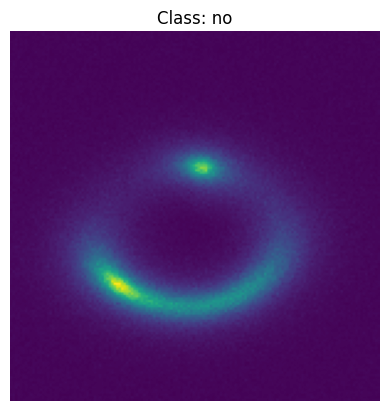

In [6]:
import random
from PIL import Image
#random.seed(42)

images_path_list = list(image_path.glob("*/*/*.npy"))
random_image_path = random.choice(images_path_list)
image_class = random_image_path.parent.stem
img = np.load(random_image_path)
img = np.squeeze(img)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.shape[0]}") 
print(f"Image width: {img.shape[1]}")
print(f"Image max: {img.max()}")
print(f"Image min: {img.min()}")


plt.imshow(img) 
plt.title(f"Class: {image_class}")
plt.axis("off") 
plt.show()

> Transforming image

In [30]:
auto_transforms = transforms.Compose([
    transforms.Resize(224),
])

# Comparison between Original images and transformed data 

<Figure size 1500x600 with 0 Axes>

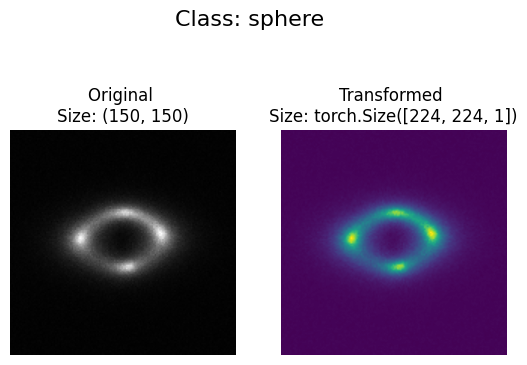

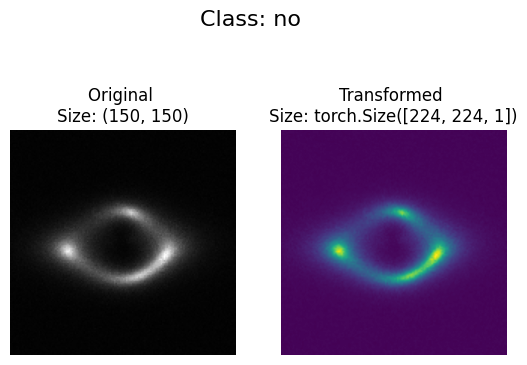

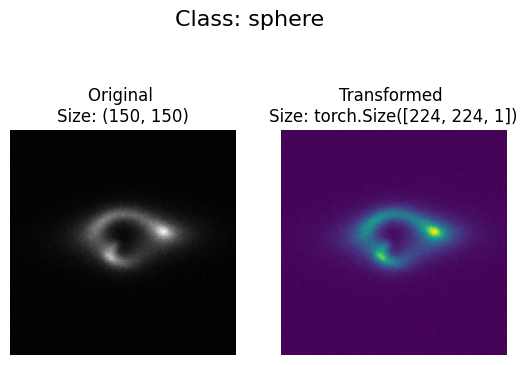

In [31]:
random_samples_idx = random.sample(images_path_list, 3)
plt.figure(figsize=(15, 6))
for i, id_ in enumerate(random_samples_idx):
    img = np.load(id_)
    img = np.squeeze(img)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title(f"Original \nSize: {img.shape}")
    ax[0].axis("off")
    
    img = torch.from_numpy(img).float().expand(1, -1, -1)
    transformed_image = auto_transforms(img).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")
    fig.suptitle(f"Class: {id_.parent.stem}", fontsize=16)

    plt.show()

# Pipeline for custom dataset

In [34]:
class NumpyDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode="train"):
        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform  
        self.file_paths = list(self.root_dir.rglob("*.npy"))
        self.labels = [path.parent.name for path in self.file_paths]
        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_class = {i: cls_name for cls_name, i in self.class_to_idx.items()}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = np.load(file_path) 
        data = torch.from_numpy(img).float().expand(1, -1, -1)
        if self.transform:
            data = self.transform(data)

        class_name = file_path.parent.name
        label = self.class_to_idx[class_name]

        return data, label

In [35]:
from torchvision import datasets
data = NumpyDataset(root_dir=train_dir, transform=auto_transforms, mode="train")

# Splitting 90:10 train-test data

In [36]:
train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
len(train_dataset), len(test_dataset)

(27000, 3000)

# Transformed data in tensor form and its shape 

In [37]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image max: {img.max()}")
print(f"Image max: {img.min()}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.0232, 0.0180, 0.0131,  ..., 0.0118, 0.0122, 0.0129],
         [0.0167, 0.0157, 0.0148,  ..., 0.0114, 0.0103, 0.0090],
         [0.0101, 0.0135, 0.0167,  ..., 0.0114, 0.0090, 0.0058],
         ...,
         [0.0092, 0.0092, 0.0088,  ..., 0.0149, 0.0172, 0.0190],
         [0.0128, 0.0119, 0.0104,  ..., 0.0130, 0.0139, 0.0149],
         [0.0154, 0.0141, 0.0122,  ..., 0.0112, 0.0097, 0.0090]]])
Image shape: torch.Size([1, 224, 224])
Image max: 0.9809821248054504
Image max: 0.0013616750948131084
Image datatype: torch.float32
Image label: 1
Label datatype: <class 'int'>


# Creating train & test dataloader

In [38]:
NUM_WORKERS = 0
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_dataset, 
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True,
                                     pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False,
                                    pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b184eef7100>,
 <torch.utils.data.dataloader.DataLoader at 0x7b184eef7520>)

# Training Step

In [39]:
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
              epoch,
              total_epoch) -> Tuple[float, float]:
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0
  
    for X, y in tqdm(iter(dataloader),desc=f"Epoch {epoch+1}/{total_epoch}", leave=True):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# Test Step

In [40]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.to(device)
    model.eval() 
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          test_pred_logits = model(X)
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Function to train the model

In [41]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         model_weight_path):
 
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  best_val_acc = 0
  for epoch in range(epochs):
      train_loss, train_acc = train_step(model=model,
                                         dataloader=train_dataloader,
                                         loss_fn=loss_fn,
                                         optimizer=optimizer,
                                         device=device,
                                         epoch=epoch,
                                         total_epoch=epochs)
      test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn,device=device)
      
      print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      if test_acc > best_val_acc:
            best_val_acc = test_acc
            print(f'Saving best model with acc {best_val_acc:.4f} at {epoch+1} epoch!')       
            torch.save(model.state_dict(), model_weight_path)

  return results

# **Model 1**

### Loading Resnet 18 model  and **fine tuning** for our classification task

In [46]:
from torchvision.models import resnet18,ResNet18_Weights
from torchinfo import summary

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device) 
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(64, 3)
).to(device)

summary(model, 
        input_size=(128, 1, 224, 224),  # Adjust batch size as needed
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [128, 1, 224, 224]   [128, 3]             --                   True
├─Conv2d (conv1)                         [128, 1, 224, 224]   [128, 64, 112, 112]  3,136                True
├─BatchNorm2d (bn1)                      [128, 64, 112, 112]  [128, 64, 112, 112]  128                  True
├─ReLU (relu)                            [128, 64, 112, 112]  [128, 64, 112, 112]  --                   --
├─MaxPool2d (maxpool)                    [128, 64, 112, 112]  [128, 64, 56, 56]    --                   --
├─Sequential (layer1)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   True
│    └─BasicBlock (0)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [128, 64, 56, 56]    [128, 64, 56, 56]    36,864               True
│    │    └─BatchN

### Training model

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

from timeit import default_timer as timer 
start_time = timer()
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device,
               model_weight_path="general_task_wt.pth")

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch 1/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.3383 | test_loss: 1.1021 | test_acc: 0.3185
Saving best model with acc 0.3185 at 1 epoch!


Epoch 2/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.0983 | train_acc: 0.3523 | test_loss: 1.1928 | test_acc: 0.3202
Saving best model with acc 0.3202 at 2 epoch!


Epoch 3/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.8759 | train_acc: 0.5692 | test_loss: 0.9251 | test_acc: 0.5833
Saving best model with acc 0.5833 at 3 epoch!


Epoch 4/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.5572 | train_acc: 0.7722 | test_loss: 0.7806 | test_acc: 0.7501
Saving best model with acc 0.7501 at 4 epoch!


Epoch 5/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3516 | train_acc: 0.8705 | test_loss: 0.3090 | test_acc: 0.8827
Saving best model with acc 0.8827 at 5 epoch!


Epoch 6/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.2767 | train_acc: 0.8997 | test_loss: 0.3005 | test_acc: 0.8973
Saving best model with acc 0.8973 at 6 epoch!


Epoch 7/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.2408 | train_acc: 0.9145 | test_loss: 0.2669 | test_acc: 0.9099
Saving best model with acc 0.9099 at 7 epoch!


Epoch 8/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.2073 | train_acc: 0.9267 | test_loss: 0.2351 | test_acc: 0.9142
Saving best model with acc 0.9142 at 8 epoch!


Epoch 9/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1819 | train_acc: 0.9375 | test_loss: 0.2278 | test_acc: 0.9243
Saving best model with acc 0.9243 at 9 epoch!


Epoch 10/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.1666 | train_acc: 0.9410 | test_loss: 0.1918 | test_acc: 0.9295
Saving best model with acc 0.9295 at 10 epoch!


Epoch 11/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.1543 | train_acc: 0.9468 | test_loss: 0.2294 | test_acc: 0.9166


Epoch 12/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1389 | train_acc: 0.9506 | test_loss: 0.2150 | test_acc: 0.9296
Saving best model with acc 0.9296 at 12 epoch!


Epoch 13/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1199 | train_acc: 0.9586 | test_loss: 0.2148 | test_acc: 0.9330
Saving best model with acc 0.9330 at 13 epoch!


Epoch 14/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.0955 | train_acc: 0.9665 | test_loss: 0.2321 | test_acc: 0.9309


Epoch 15/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.0908 | train_acc: 0.9690 | test_loss: 0.3271 | test_acc: 0.9158


Epoch 16/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.0865 | train_acc: 0.9697 | test_loss: 0.2643 | test_acc: 0.9182


Epoch 17/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.0613 | train_acc: 0.9800 | test_loss: 0.2574 | test_acc: 0.9293


Epoch 18/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.0533 | train_acc: 0.9819 | test_loss: 0.3303 | test_acc: 0.8918


Epoch 19/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.0516 | train_acc: 0.9820 | test_loss: 0.4013 | test_acc: 0.9225


Epoch 20/20:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.0449 | train_acc: 0.9845 | test_loss: 0.3415 | test_acc: 0.9136
[INFO] Total training time: 1517.328 seconds


### Plotting losses and accuracy for model 1

In [48]:
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_training_metrics(train_loss, test_loss, train_acc, test_acc):
    epochs = list(range(1, len(train_loss) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
    plt.plot(epochs, test_loss, label="Test Loss", marker='s', linestyle='--', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(epochs, test_acc, label="Test Accuracy", marker='s', linestyle='--', color='g')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    

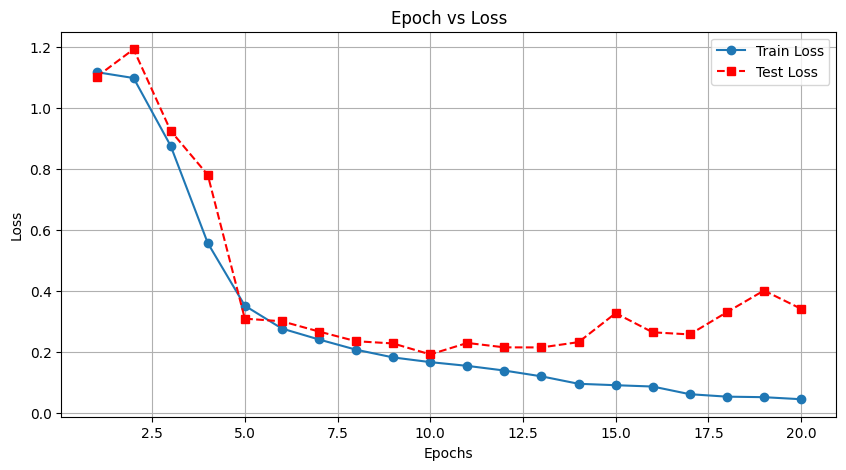

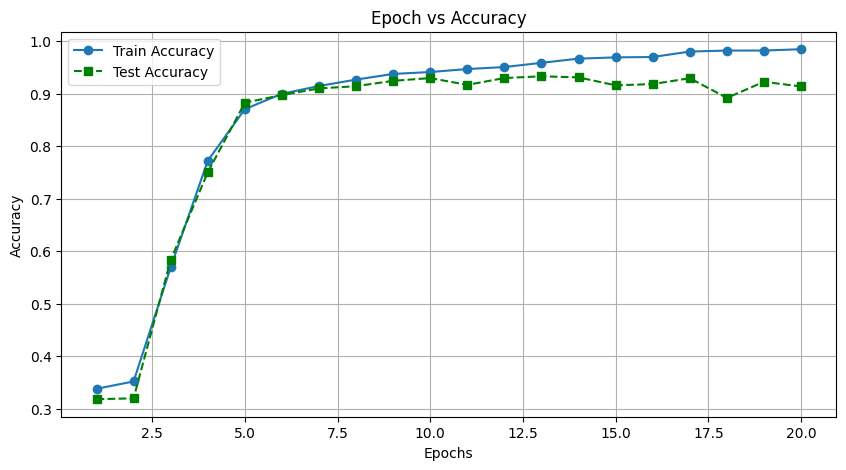

In [49]:
plot_training_metrics(results["train_loss"],
                      results["test_loss"],
                      results["train_acc"],
                      results["test_acc"])

## Loading val data and creating dataloader for val data

In [50]:
val_data = NumpyDataset(val_dir, transform = auto_transforms, mode="val")
test_dataloader = DataLoader(dataset=val_data,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

### Prediction on val data

In [51]:
def compute_predictions(model, test_dataloader, num_classes=3, device="cuda"):
    model.to(device)
    model.eval()
    
    outputs = torch.empty(len(test_dataloader.dataset), num_classes, device=device)
    y_pred = torch.zeros_like(outputs)
    y_true = torch.zeros_like(outputs)
    with torch.no_grad():
        start_idx = 0
        for X, y in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            batch_size = X.shape[0]
    
            batch_outputs = model(X)
            outputs[start_idx: start_idx + batch_size] = batch_outputs    
            y_true[torch.arange(start_idx, start_idx + batch_size), y] = 1    
            start_idx += batch_size
    y_pred[torch.arange(outputs.shape[0]), torch.argmax(outputs, dim=1)] = 1  
    y_pred = y_pred.to(torch.int)
    return y_true.cpu().numpy(), y_pred.cpu().numpy()
y_true, y_pred = compute_predictions(model, test_dataloader, num_classes=3, device="cuda")

100%|██████████| 7500/7500 [00:36<00:00, 204.62it/s]


### confusion matrix for 3 classes for model 1

In [52]:
def plot_confusion_matrices(y_true, y_pred, class_labels):
    fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 4))

    for i, (label, ax) in enumerate(zip(class_labels, axes)):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_title(f"{label} (Class {i})")

    plt.tight_layout()
    plt.show()

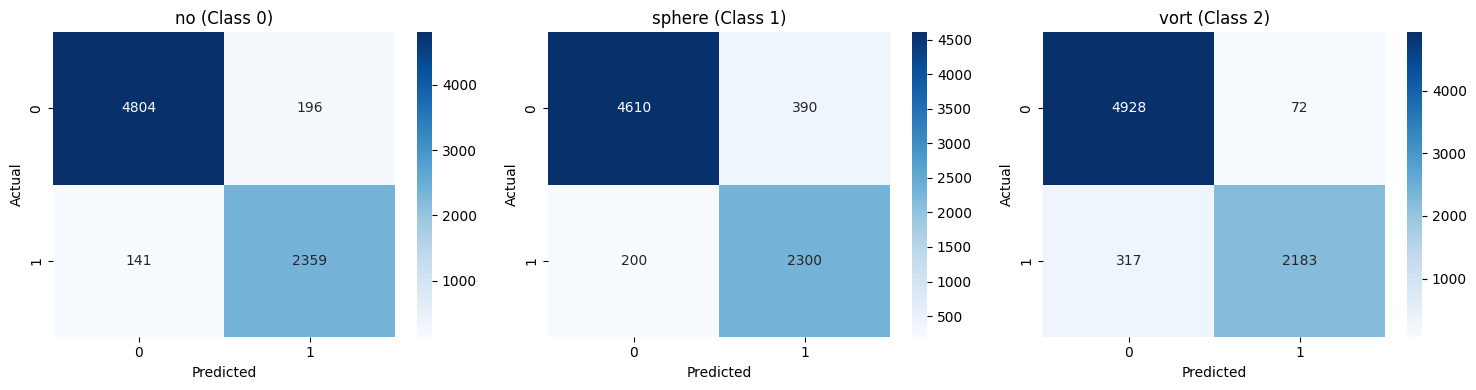

In [53]:
plot_confusion_matrices(y_true,y_pred, class_labels=data.classes)

### ROC and AUC for model 1

In [54]:
def plot_roc_curves(y_true_np, output_np, num_classes=3):
    plt.figure(figsize=(12, 6))

    for i in range(num_classes):
        fpr, tpr, thresholds = roc_curve(y_true_np[:, i], output_np[:, i])
        roc_auc = auc(fpr, tpr)

        print(f"Class {i}: AUC = {roc_auc:.2f}")
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc='lower right')
    plt.show()

Class 0: AUC = 0.95
Class 1: AUC = 0.92
Class 2: AUC = 0.93


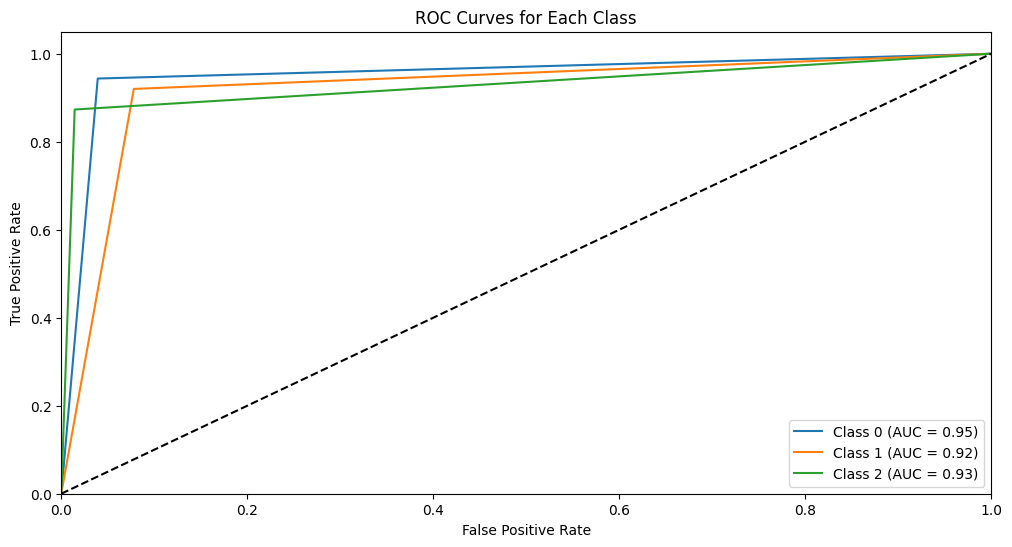

In [55]:
plot_roc_curves(y_true, y_pred, num_classes=3)